# Iceland Litli-Hrútur Eruption Figures and Analysis

Analysis of data collected form the Iceland Litli-Hrútur Eruption on July 16-17, 2023

This analysis fits a 2 dimensional Gaussian model to the plume data with the following procedure:
To estimate the total flux of the plume, we perform the following procedure.
1. Normalise the transect span by combining latitude and longitude into distance away from launch location in meters.
2. Isolate the plume by setting an ambient CO$_2$ threshold and removing data points that fall less than that threshold.
3. Fit a Gaussian curve to the data set as follows.
    1. Calculate the mean μ and standard deviation σ of the CO$_2$ across the transect.
    2. Scale the two-dimensional gaussian curve to fit the data by choosing a constant amplitude a using gradient descent to minimize the $χ^2$ difference between the model and plume sample data. We assume that the gaussian shape is uniform in both $x$ and $y$ dimensions.
\begin{align}
    \text{gaussianModel2D}() &=  a \frac{e^{-\frac{1}{2}(\frac{x -\mu_x}{\sigma_x})^2}}{\sigma_x \sqrt{2 \pi}} \:  \frac{e^{-\frac{1}{2}(\frac{y - \mu_y}{\sigma_y})^2}}{\sigma_y \sqrt{2 \pi}} \\
        &= a \frac{e^{-\frac{1}{2}(\frac{x -\mu}{\sigma})^2}}{\sigma \sqrt{2 \pi}} \:  \frac{e^{-\frac{1}{2}(\frac{0}{\sigma})^2}}{\sigma \sqrt{2 \pi}} & y = 0, \mu_y = 0, \sigma = \sigma_x, \sigma_y = \sigma, \mu = \mu_x \\
        &= a \frac{e^{-\frac{1}{2}(\frac{x -\mu}{\sigma})^2}}{\sigma^2 2 \pi}
\end{align}
    
4. Integrate the two-dimensional gaussian and multiply by the measured wind speed $v$ gives the flux of the plume in $mgS^{−1}m^{−2}$. Multiplying this again by the number of seconds in a day, and the number of mg in a ton gives the flux in t $day^{−1}$.

\begin{align}
    \int \text{gaussianModel2D}() &= a \int \frac{e^{-\frac{1}{2}(\frac{x -\mu}{\sigma})^2}}{\sigma^2 2 \pi} \\
&= a \\
    \text{flux}(a, v) &= v \, a
\end{align}

In [1]:
%matplotlib inline

import os, sys, math, datetime, time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
})

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.logtocsv import parse_log
from dragonfly_util.plot_util import *
from geopy.distance import geodesic

# Read data from logs

In [2]:
# Parse the dragonfly specific log files
def read_data(file):
    return parse_log(file, skip_zeroing=False)

# Filter the data by the given predicate (i.e. between(start, end))
def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

# Define a start and end date/time predicate
def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0


# Read in the main log file
df1_data = read_data("data/run.log")

# Seprate the logs into the given segments on day 1 and day 2
day1 = filter_data(df1_data, between('2023-7-15 0:00:00.0', '2023-7-15 23:59:00.0'))
day2 = filter_data(df1_data, between('2023-7-16 0:00:00.0', '2023-7-17 23:59:00.0'))

day1_flight1 = filter_data(df1_data, between('2023-7-15 14:00:00.0', '2023-7-15 14:15:00.0'))

day2_flight1 = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:26:00.0'))
day2_flight1a = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:22:30.0'))
day2_flight1b = filter_data(df1_data, between('2023-7-16 17:22:30.0', '2023-7-16 17:26:00.0'))
day2_flight2 = filter_data(df1_data, between('2023-7-16 20:17:00.0', '2023-7-16 20:30:00.0'))

day2_flight2a = filter_data(df1_data, between('2023-7-16 20:18:30.0', '2023-7-16 20:19:00.0'))

## Define Gaussian flux fit methods

In [3]:
# Calculates a 2 dimensional Gaussian distribution
def gaussian(amplitude, x, y, xmean, ymean, xstd_dev, ystd_dev):
    return amplitude * \
        (np.exp(- (((x - xmean) / xstd_dev) ** 2) / 2) / (xstd_dev * math.sqrt(2 * math.pi))) * \
        (np.exp(- (((y - ymean) / ystd_dev) ** 2) / 2) / (ystd_dev * math.sqrt(2 * math.pi)))

# Calculates a 1 dimensional slice through a semetrical 2 dimensional Gaussian
def gaussian_slice(amplitude, x, mean, std_dev):
    return gaussian(amplitude, x, 0, mean, 0, std_dev, std_dev)

# Calculate the X^2 difference between the data and model
def difference(distance_data, amplitude, mean, std_dev, ambient):
    difference_sum = 0
    for i in range(len(distance_data)) :
        if distance_data[i]["value"] > ambient:
            calculated_value = gaussian_slice(amplitude, distance_data[i]["distance"], mean, std_dev)
            calculated_difference = distance_data[i]["value"] - ambient
            difference = calculated_value - calculated_difference
            difference_sum = difference_sum + (difference ** 2)
    return difference_sum

# Fits the amplitude of a gaussian defined by mean and std_dev to the given data
def fit_data(distance_data, ambient, mean, std_dev, current, learning_rate, max_iter, precision=0.0000001):

    above_ambient_distance_data = [d for d in distance_data if d["value"] > ambient]
    x_values = [d["distance"] for d in above_ambient_distance_data]
    y_values = [d["value"] - ambient for d in above_ambient_distance_data]

    def gaussian(x, amplitude):
        return gaussian_slice(amplitude, x, mean, std_dev)

    params, covariance = curve_fit(gaussian, x_values, y_values, ftol=precision, p0=[current])

    a_fit = params[0]

    return a_fit, difference(distance_data, a_fit, mean, std_dev, ambient)

# Calculate the flux in kg/s from the given CO2 concentration over m2
def flux(C):
    wind_speed = 10 # m/s
    kg_per_g = math.pow(10, -3) # kg / g
    CO2_molecular_weight = 44.01 # g / mol
    l_per_m3 = 1000 # l / m3
    moles_per_liter = 1 / 22.80 # mol / l
    return C * CO2_molecular_weight * moles_per_liter / l_per_m3 * wind_speed * kg_per_g

def area(distance_data, ambient):
    area_sum = 0
    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)

    return area_sum

## Define plotting methods

In [4]:
# Render the scatter plot of the co2 concentraion / distance data
def render_scatter_areas(ax, distance_data, ambient):
    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))

# Render the combined plot fits
def render_distance_data(starting_position, data, ambient, title, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=700, angle=math.pi/2, delegate=None):
    total = 0
    count = 0
    
    # Calculate the distance from starting position
    distance_data = []
    max_distance = 0
    distance_angle_scale = math.sin(angle)
    coord_start = (starting_position.lat, starting_position.lon)
    
    for d in data:
        coord_curr = (d.lat, d.lon)
        distance = geodesic(coord_start, coord_curr).meters * distance_angle_scale
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
    # Calculate the mean
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
        
    mean = max_distance if use_max else total / count
    
    # Calculate the standard deviation
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
    
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))

    # Fit the gaussian model to the data
    [minimum_s, minimum_x2] = fit_data(distance_data, ambient, mean, std_dev, 4500, 100, 1000)
    
    scatter_area = area(distance_data, ambient)
    
    print("{} m: {:.2f} sd: {:.2f} a: {:.2f} x2: {:.2f} flux:{:.2f}kg/s".
          format(title, minimum_s, mean, std_dev, minimum_x2, flux(minimum_s)))
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian_slice(minimum_s, x, mean, std_dev)]
    
    if delegate is not None:
        delegate(ax)
    
    ax.title.set_text(title)
    render_scatter_areas(ax, distance_data, ambient)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    if plot_gaussian:
        ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}kg/s'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance East from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(min_distance, limit_distance * distance_angle_scale)
        
    ax.set_ylim(400, max_co2)
    if legend:
        ax.legend()
    ax.plot()

# Save the current figure off to pdf and png
def saveFigure(plt, name, dpi=72):
    figure_path = 'figures'
    if not os.path.exists(figure_path):
       os.makedirs(figure_path)
    plt.savefig(figure_path + "/" + name + ".pdf", format="pdf", dpi=dpi)
    plt.savefig(figure_path + "/" + name + ".png", format="png", dpi=dpi)

## Day 2 transects 1 and 2 plume encounters

Day 2 Transect out m: 956604.03 sd: 375.09 a: 17.92 x2: 336176.53 flux:18.46kg/s
Day 2 Transect back m: 2571697.45 sd: 310.66 a: 46.05 x2: 721234.97 flux:49.64kg/s


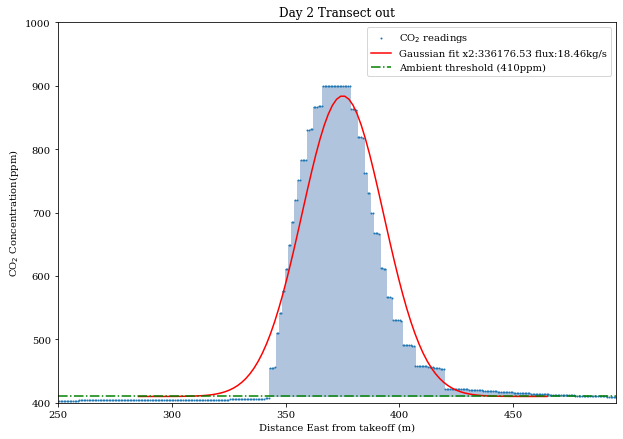

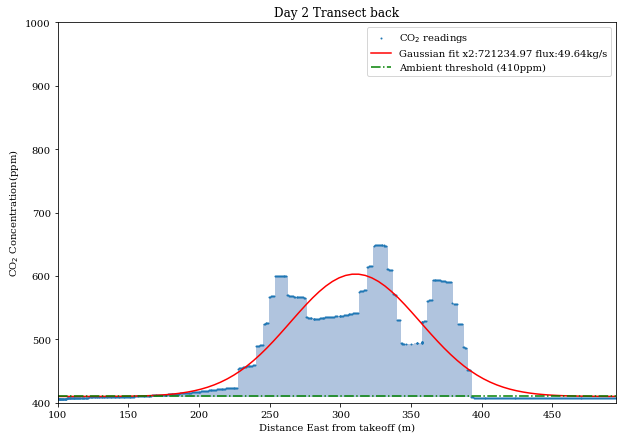

In [5]:
ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1a, 410, 'Day 2 Transect out', axs, min_distance=250, limit_distance=700, max_co2=1000, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect1', dpi=300)

ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1b, 410, 'Day 2 Transect back', axs, min_distance=100, limit_distance=700, max_co2=1000, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect2', dpi=300)

## Day 2 transect 3 plume encounter

Day 2 Curtain m: 1752376.05 sd: 332.18 a: 20.83 x2: 3055289.71 flux:33.83kg/s


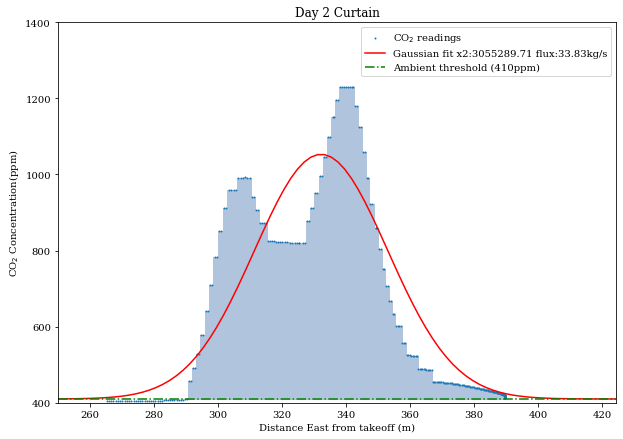

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1[0], day2_flight2a, 410, 'Day 2 Curtain', axs, min_distance=250, limit_distance=600, max_co2=1400, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect3', dpi=300)

## Data validation
Check the gaussian fit against the definite integral

In [7]:
from scipy.integrate import dblquad
import numpy as np

mean = 115348.14 
std_dev = 103.86
amplitude = 6.22

# Define the function to be integrated
def my_function(x, y):
    return gaussian(amplitude, x, y, mean, mean, std_dev, std_dev)

# Set the integration limits
lower_limit = mean - (10 * std_dev)
upper_limit = mean + (10 * std_dev)

# Calculate the definite integral
result, error = dblquad(my_function, lower_limit, upper_limit, lower_limit, upper_limit)

print(f"The definite integral result: {result}")
print(f"Estimated error in the result: {error}")


The definite integral result: 6.219999999999256
Estimated error in the result: 1.4381627643801222e-08


## Data validation
Render a 3D representation of the data and gaussian fit and compare this against the same area cylinder

<IPython.core.display.Javascript object>


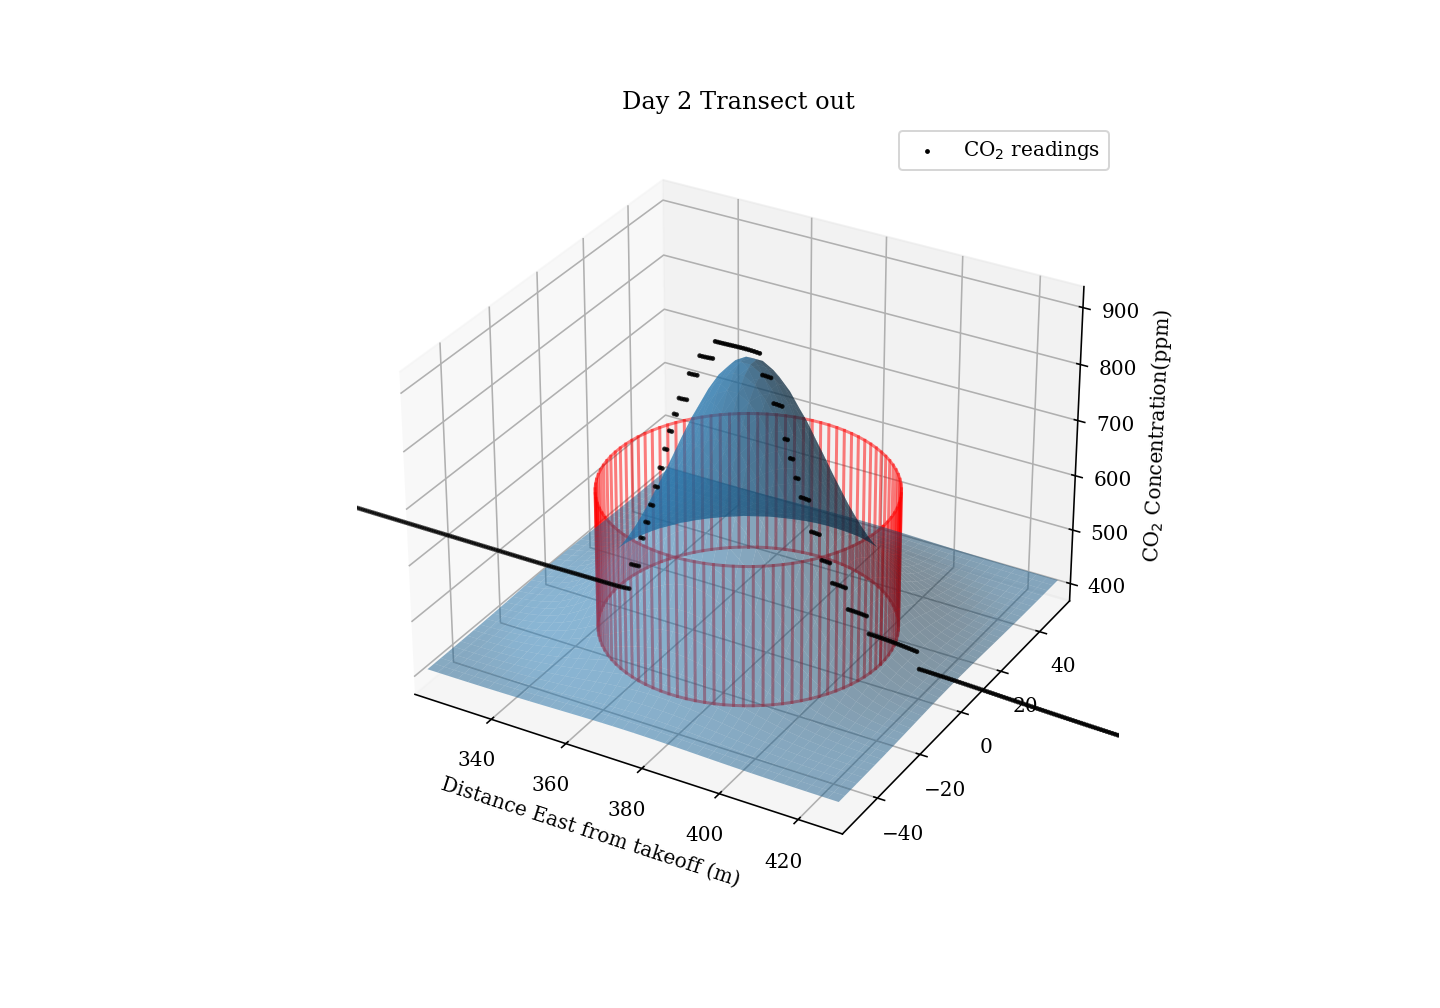

flux cylinder (ppm:248.38444542785922): 18.45129610788102
flux gaussian: 18.45129610788102


In [8]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import math

def render_3d(starting_position, data, ambient, title, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=700, angle=math.pi/2, delegate=None):
    total = 0
    count = 0
    
    distance_data = []
    max_distance = 0
    distance_angle_scale = math.sin(angle)
    starting_position_coods = (starting_position.lat, starting_position.lon)
    
    for d in data:
        d_coords = (d.lat, d.lon)
        distance = geodesic(d_coords, starting_position_coods).meters * distance_angle_scale
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
    
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))

    [minimum_s, minimum_x2] = fit_data(distance_data, ambient, mean, std_dev, 4500, 100, 1000)
        
    # Create a 3D grid
    std_dev_scale = 3
    x = np.linspace(mean - std_dev_scale*std_dev, mean + std_dev_scale*std_dev, 40)
    y = np.linspace(0 - std_dev_scale*std_dev, 0 + std_dev_scale*std_dev, 40)
    x, y = np.meshgrid(x, y)

    # Create a 2D Gaussian distribution
    z = gaussian(minimum_s, x, y, mean, 0, std_dev, std_dev) + ambient
        
    ax.plot_surface(x, y, z, alpha=0.5)
    
    ax.title.set_text(title)
    ax.scatter([d["distance"] for d in distance_data], [0 for d in distance_data], [d["value"] for d in distance_data], s=2, c='k', label="CO$_2$ readings")

    ax.set_xlabel('Distance East from takeoff (m)')
    ax.set_zlabel('CO$_2$ Concentration(ppm)')
        
    ax.set_xlim(mean - std_dev_scale*std_dev, mean + std_dev_scale*std_dev)
    ax.set_ylim(0 - std_dev_scale*std_dev, 0 + std_dev_scale*std_dev)
    if legend:
        ax.legend()
#     ax.plot()

    def plot_cylinder(ax, radius, min_height, height, x_offset=0, num_points=100):
        # Create points for the cylinder surface
        theta = np.linspace(0, 2*np.pi, num_points)
        x = radius * np.cos(theta) + x_offset
        y = radius * np.sin(theta)

        # Create points for the top and bottom circles
        z_top = np.full_like(theta, min_height + height)
        z_bottom = np.full_like(theta, min_height)

        # Plot the cylinder surface
        ax.plot(x, y, z_top, color='r', alpha=0.5)
        ax.plot(x, y, z_bottom, color='r', alpha=0.5)

        # Connect the corresponding points to form the cylinder sides
        for i in range(num_points):
            ax.plot([x[i], x[i]], [y[i], y[i]], [z_top[i], z_bottom[i]], color='r', alpha=0.5)
            
    calc_flux = flux(minimum_s)
    radius = 35
    ave_ppm = minimum_s / (math.pi * (radius ** 2))
    plot_cylinder(ax, radius, ambient, ave_ppm, mean)

    print(f'flux cylinder (ppm:{ave_ppm}): {flux(ave_ppm * math.pi * (radius ** 2))}')
    print(f'flux gaussian: {flux(minimum_s)}')
    

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

render_3d(day2_flight1a[0], day2_flight1a, 410, 'Day 2 Transect out', ax, limit_distance=250, max_co2=1000, legend=True, angle=math.pi/4)

## All Data

<IPython.core.display.Javascript object>


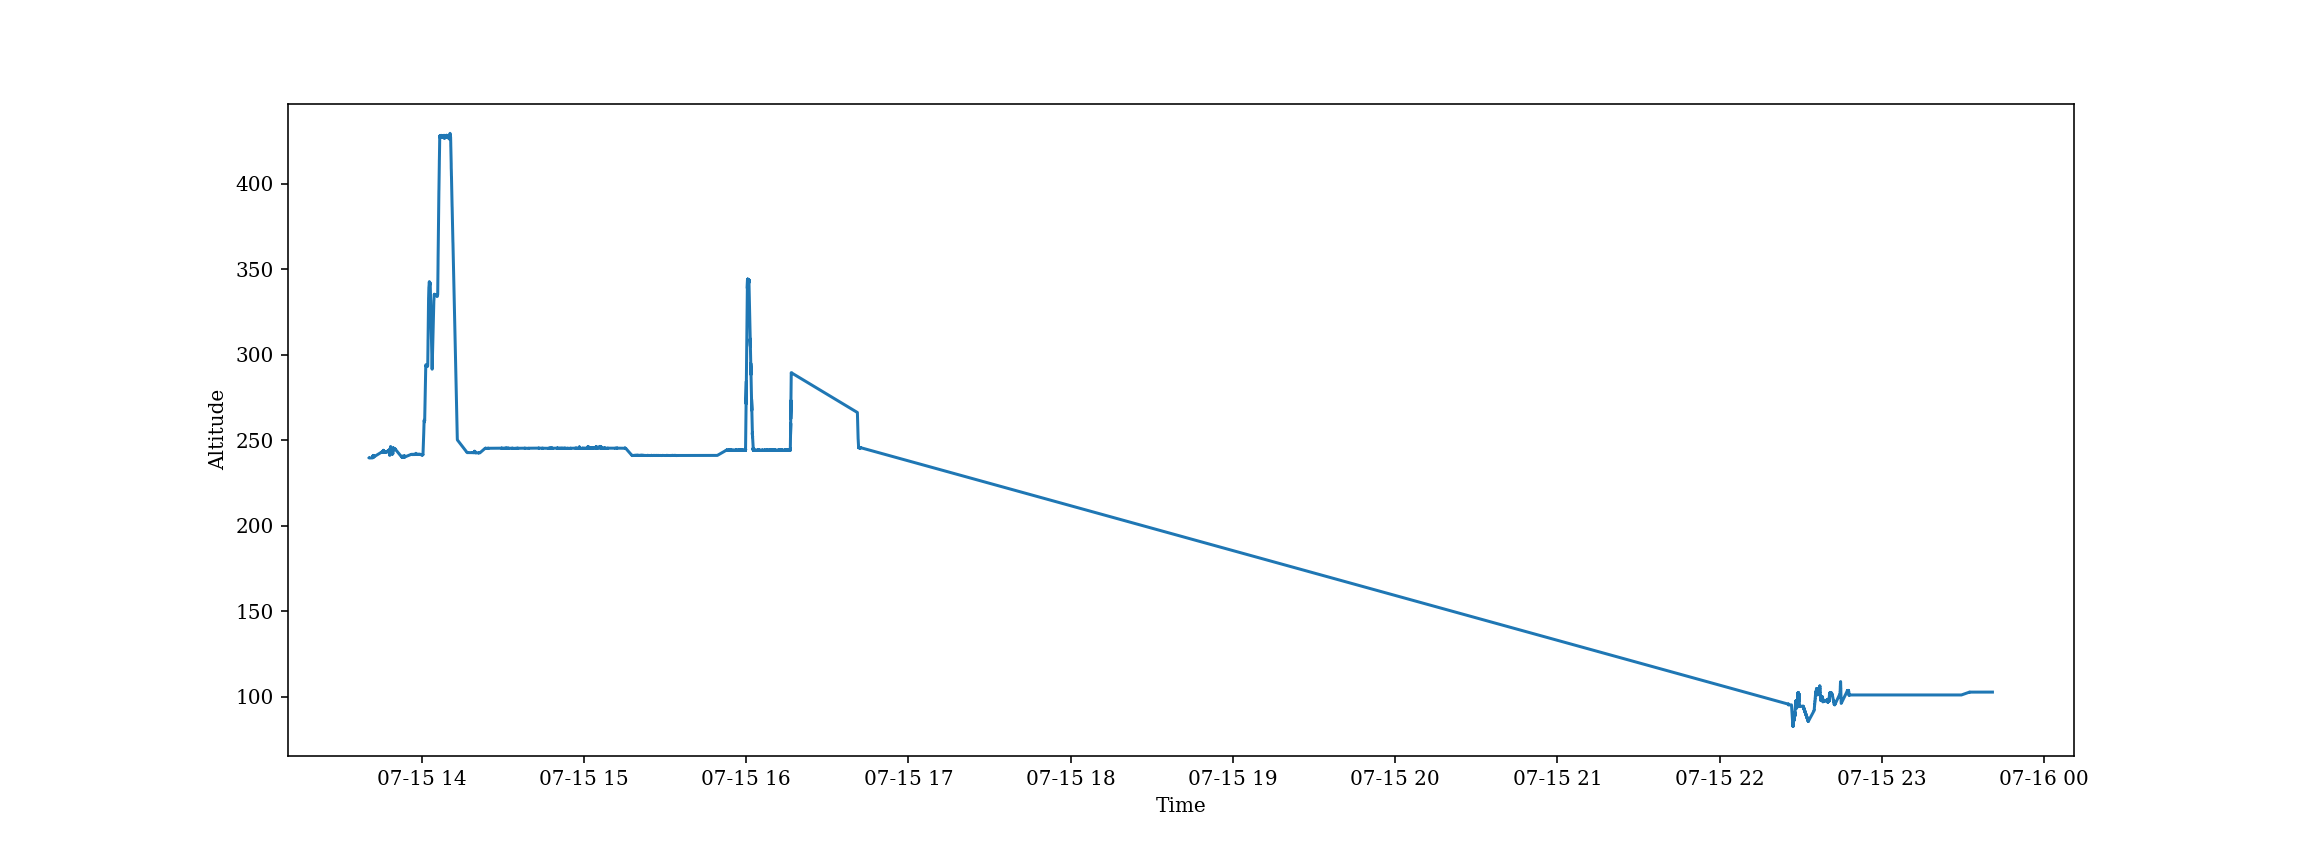

<IPython.core.display.Javascript object>


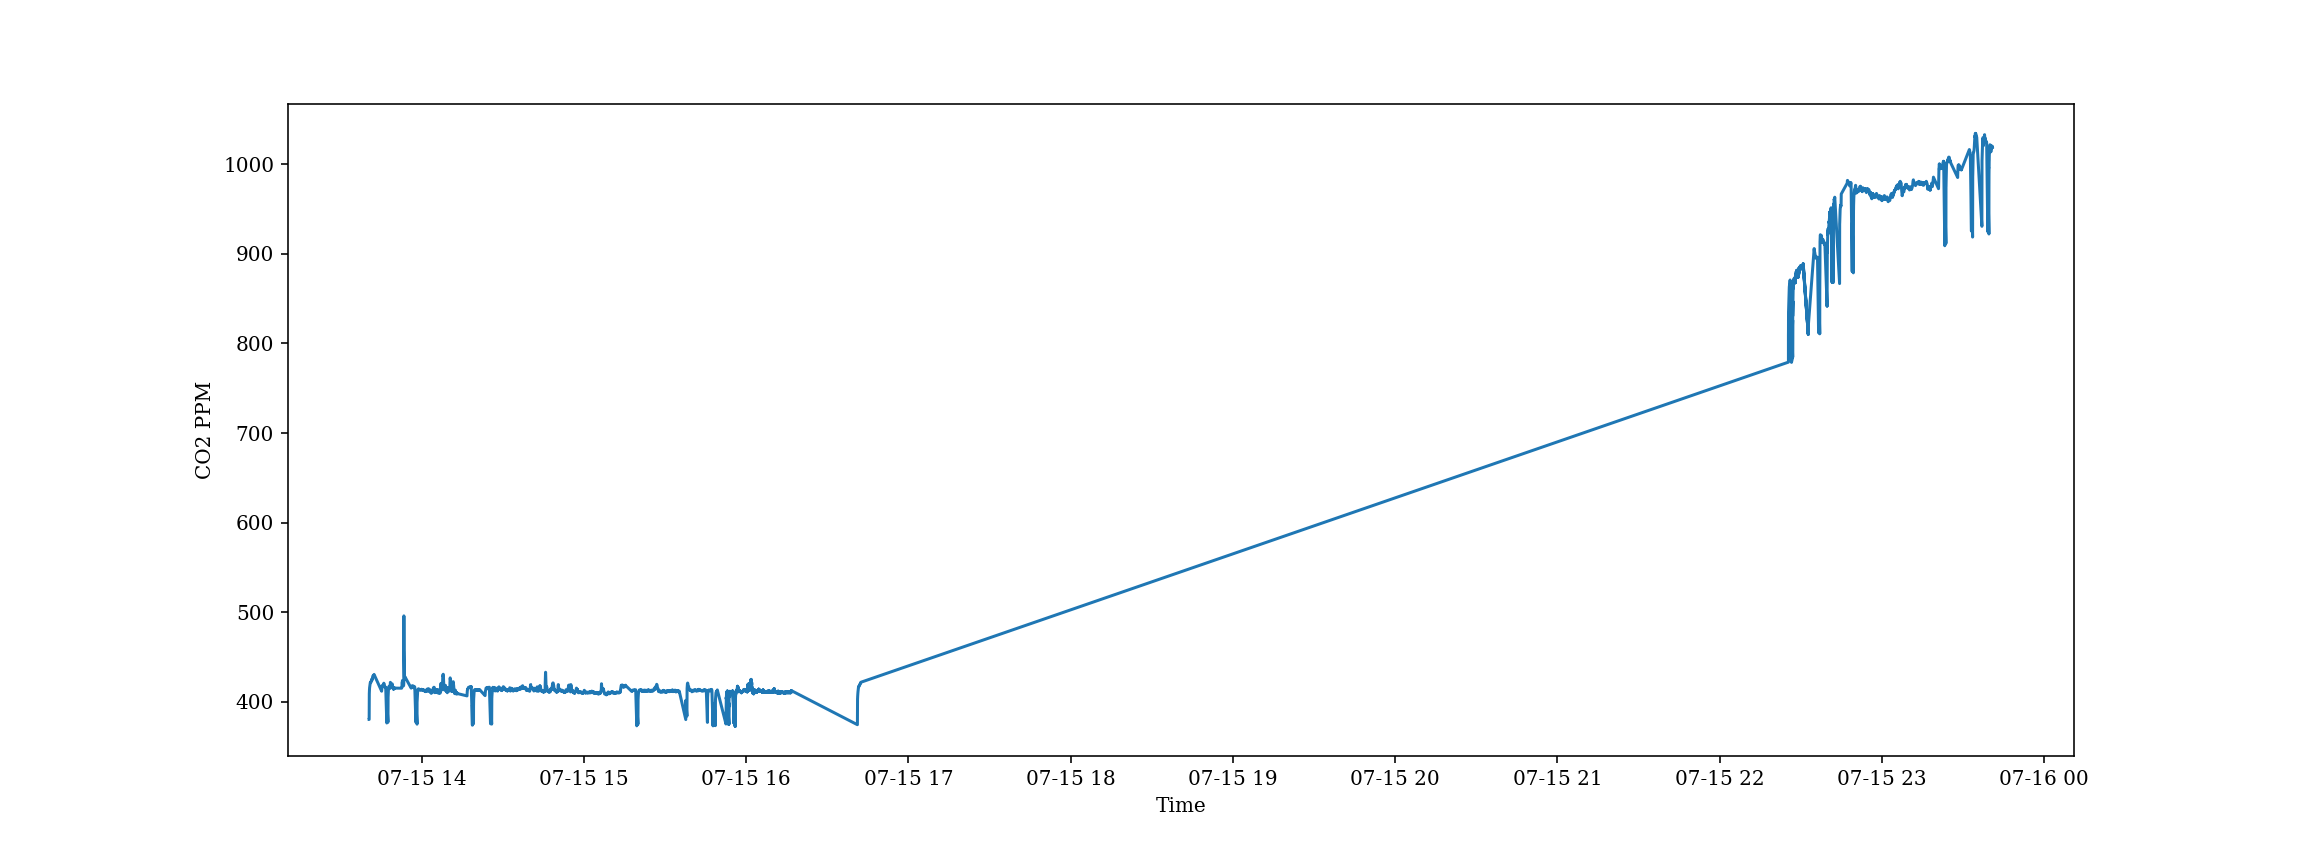

<IPython.core.display.Javascript object>


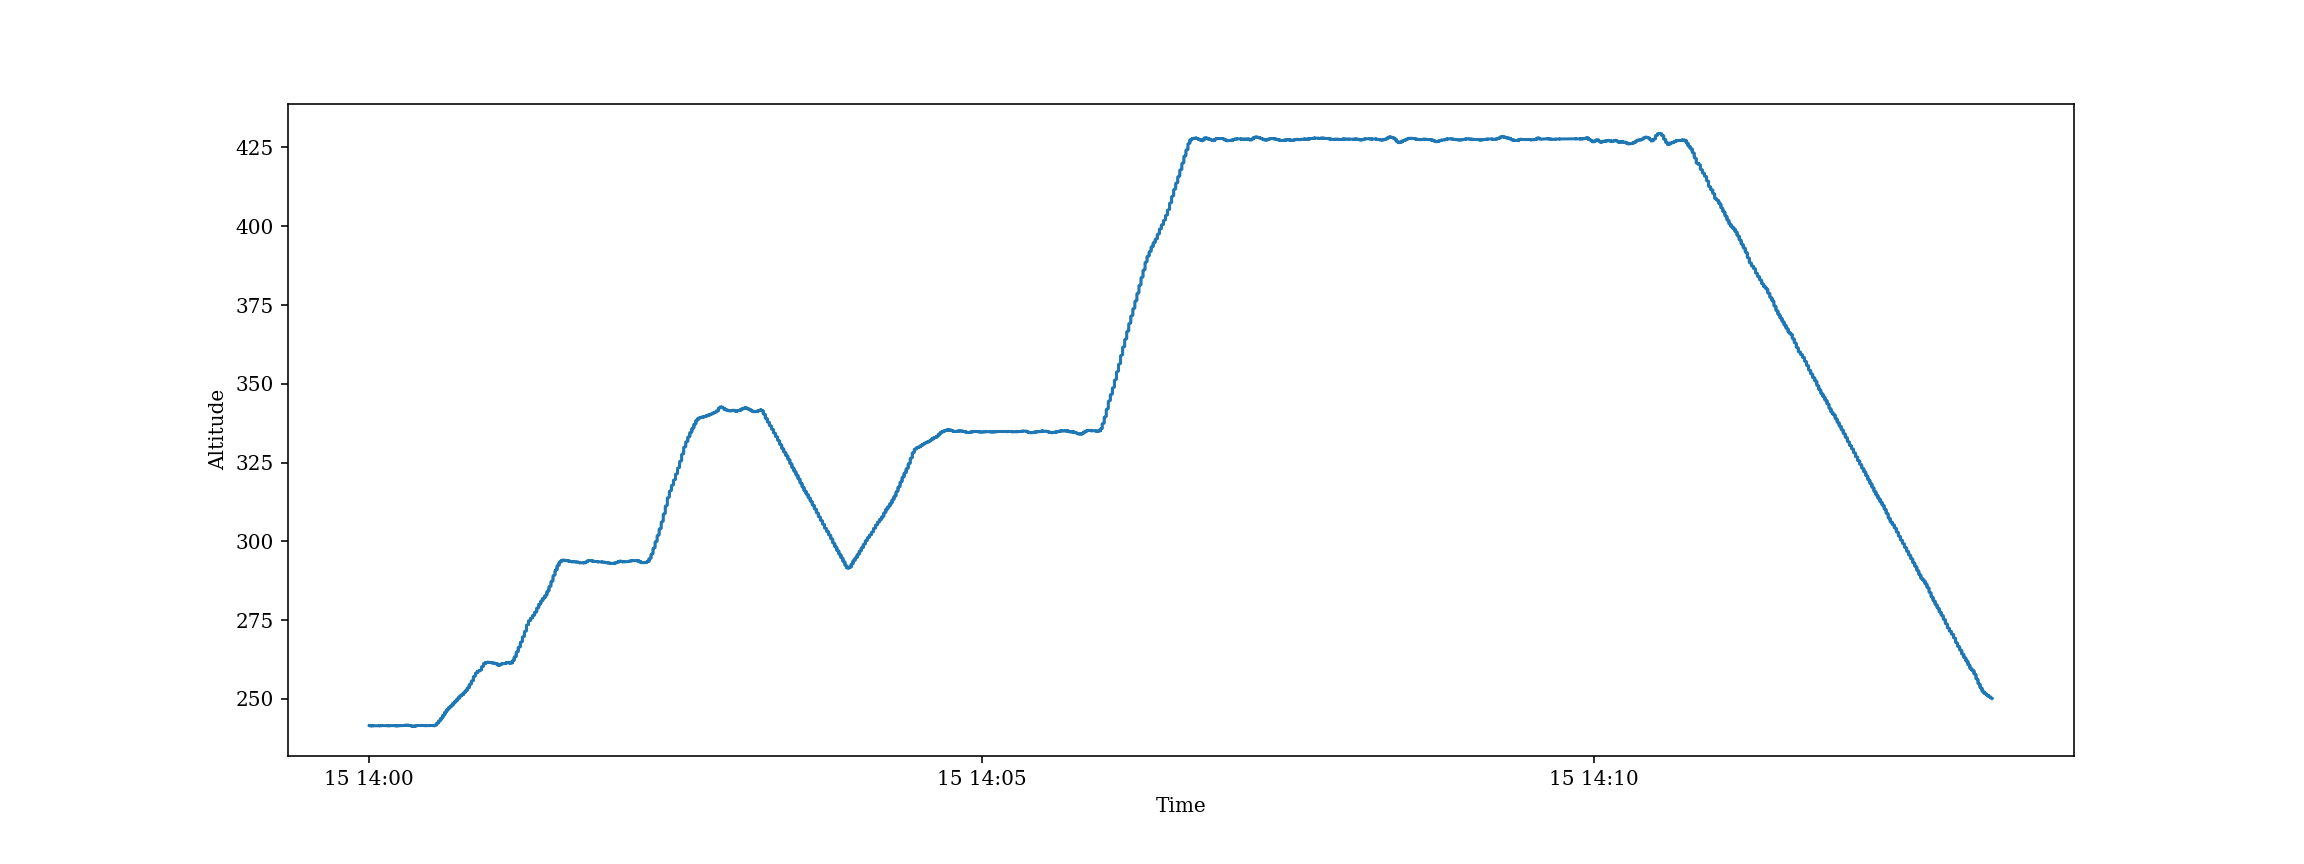

<IPython.core.display.Javascript object>


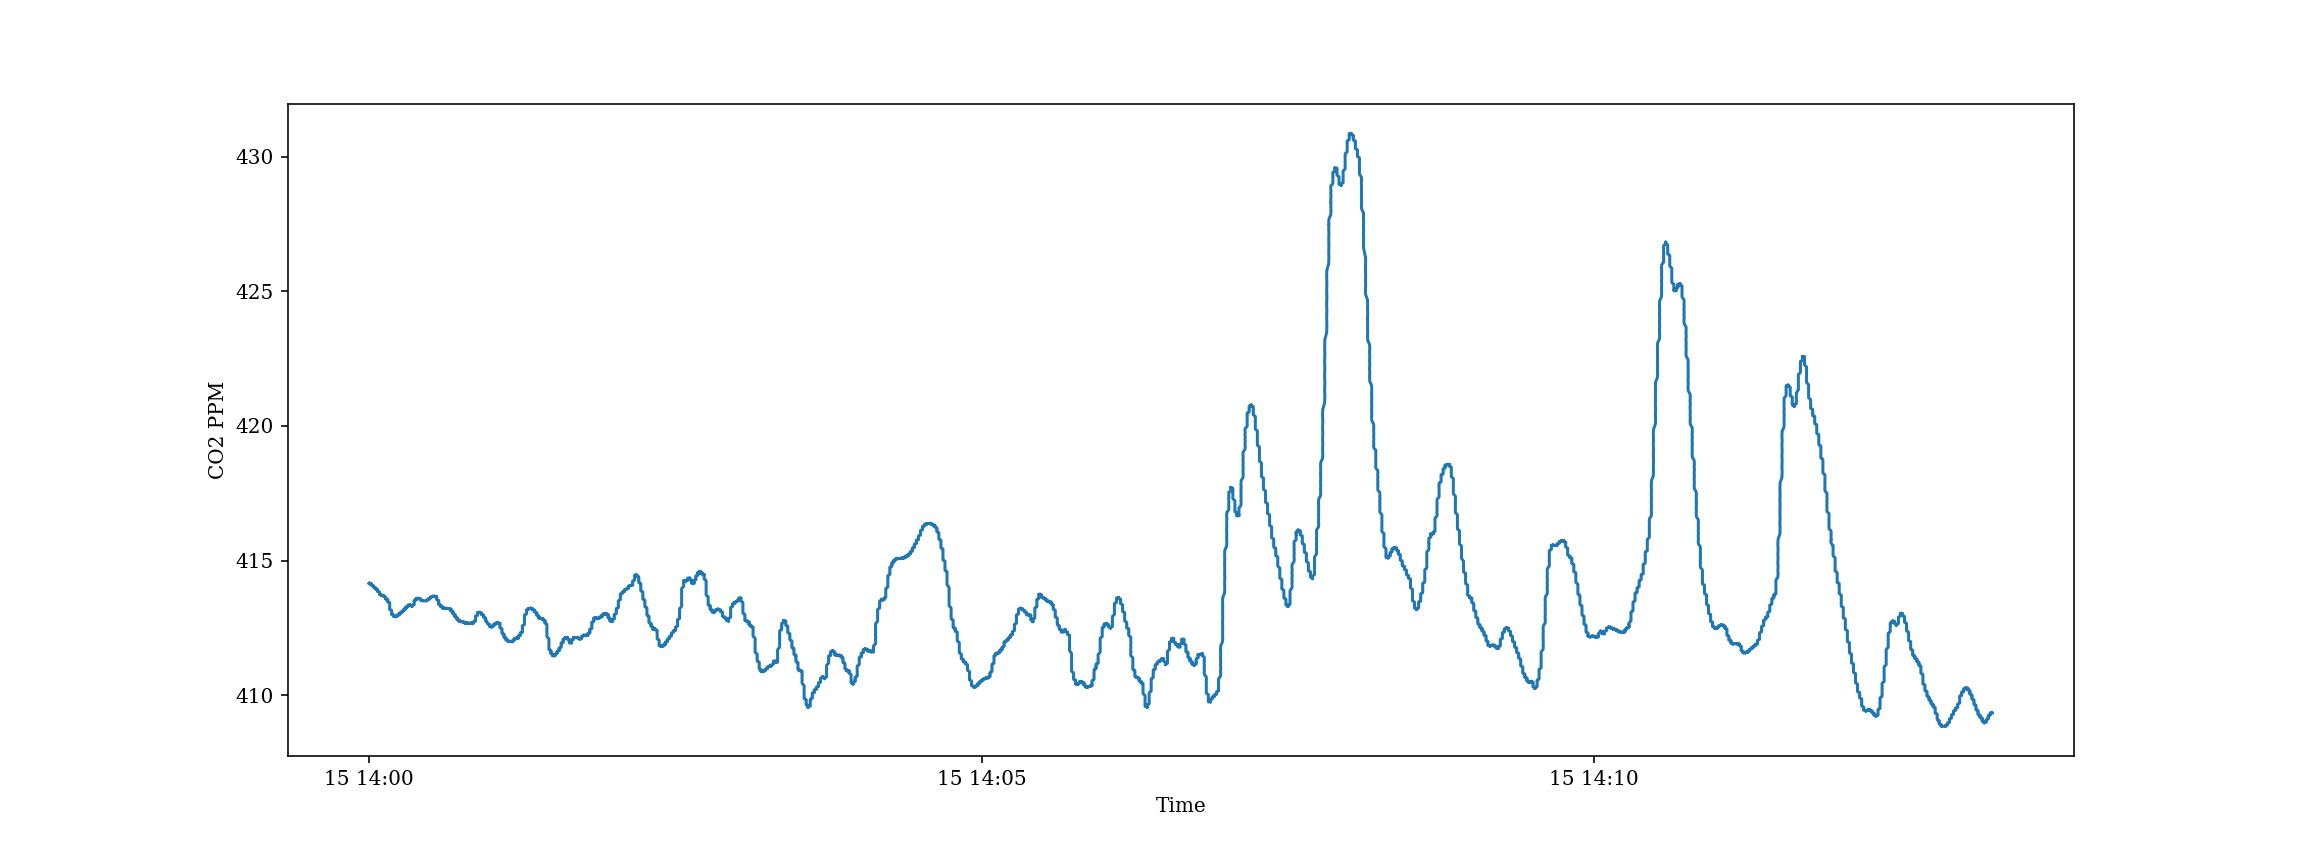

<IPython.core.display.Javascript object>


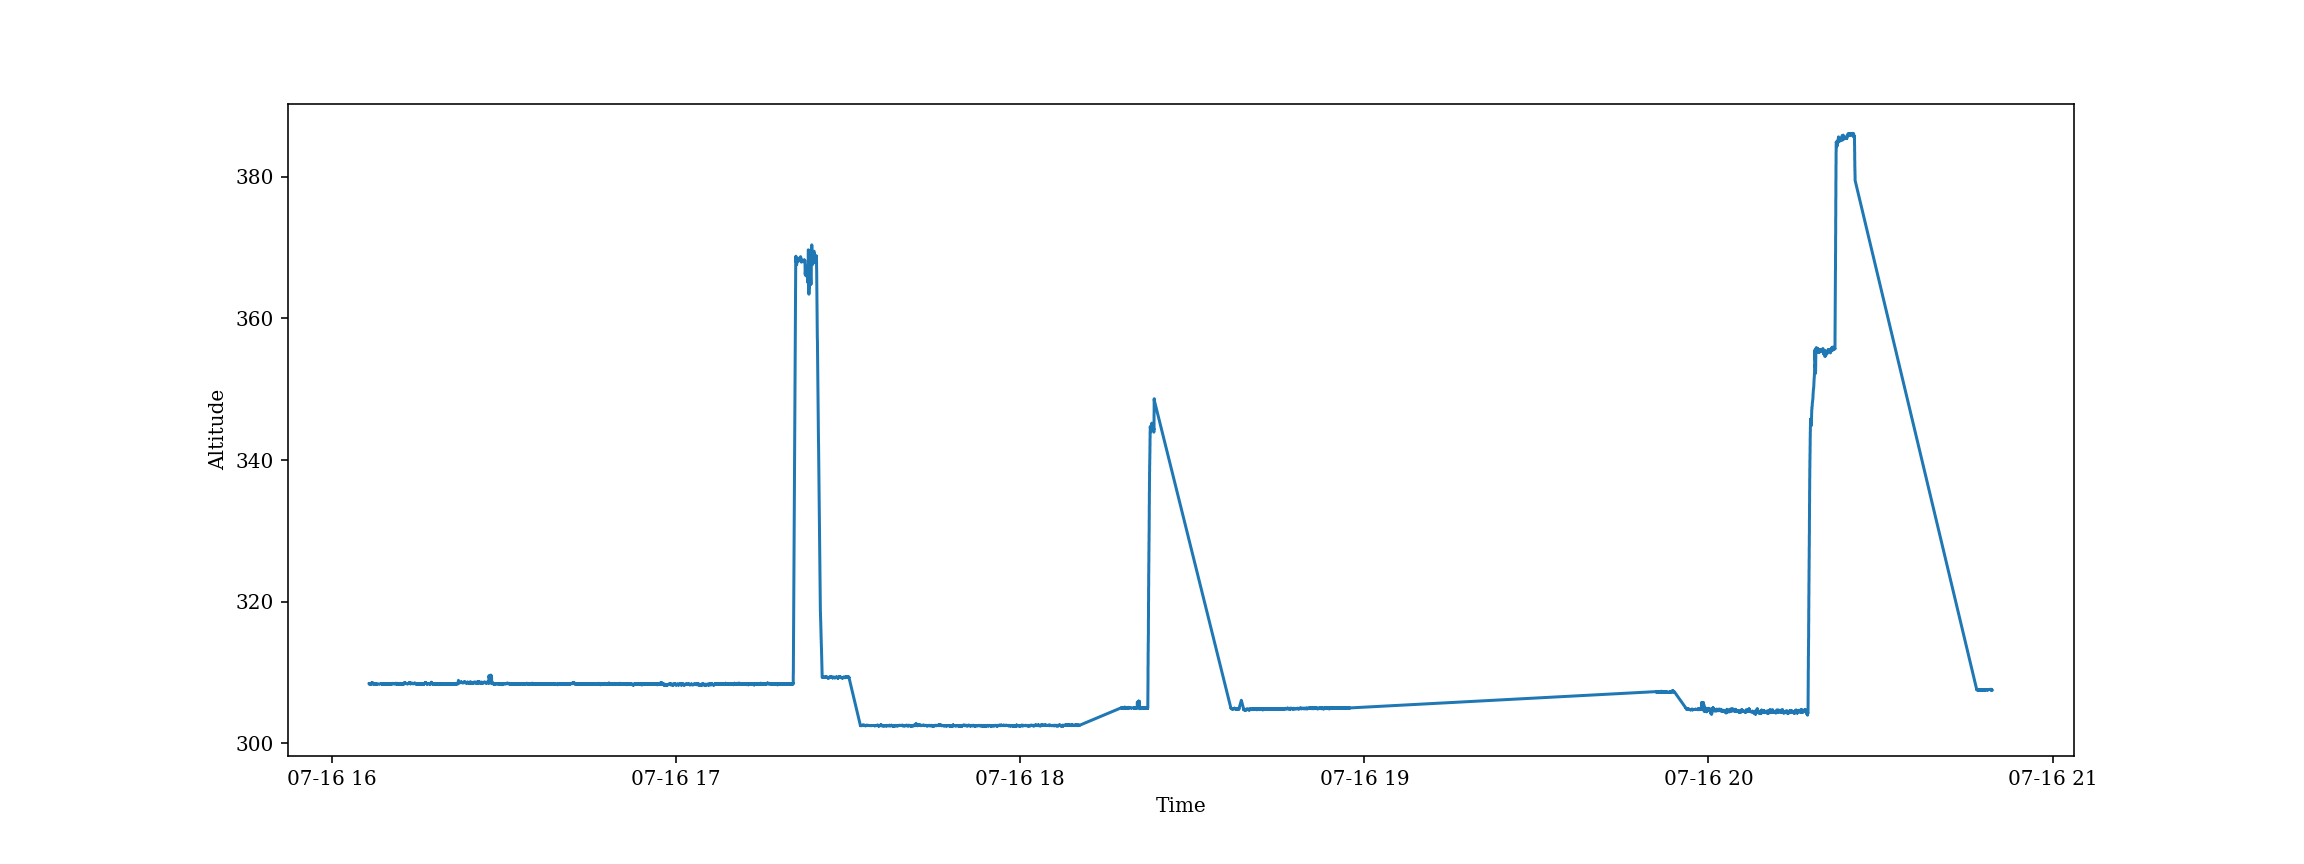

<IPython.core.display.Javascript object>


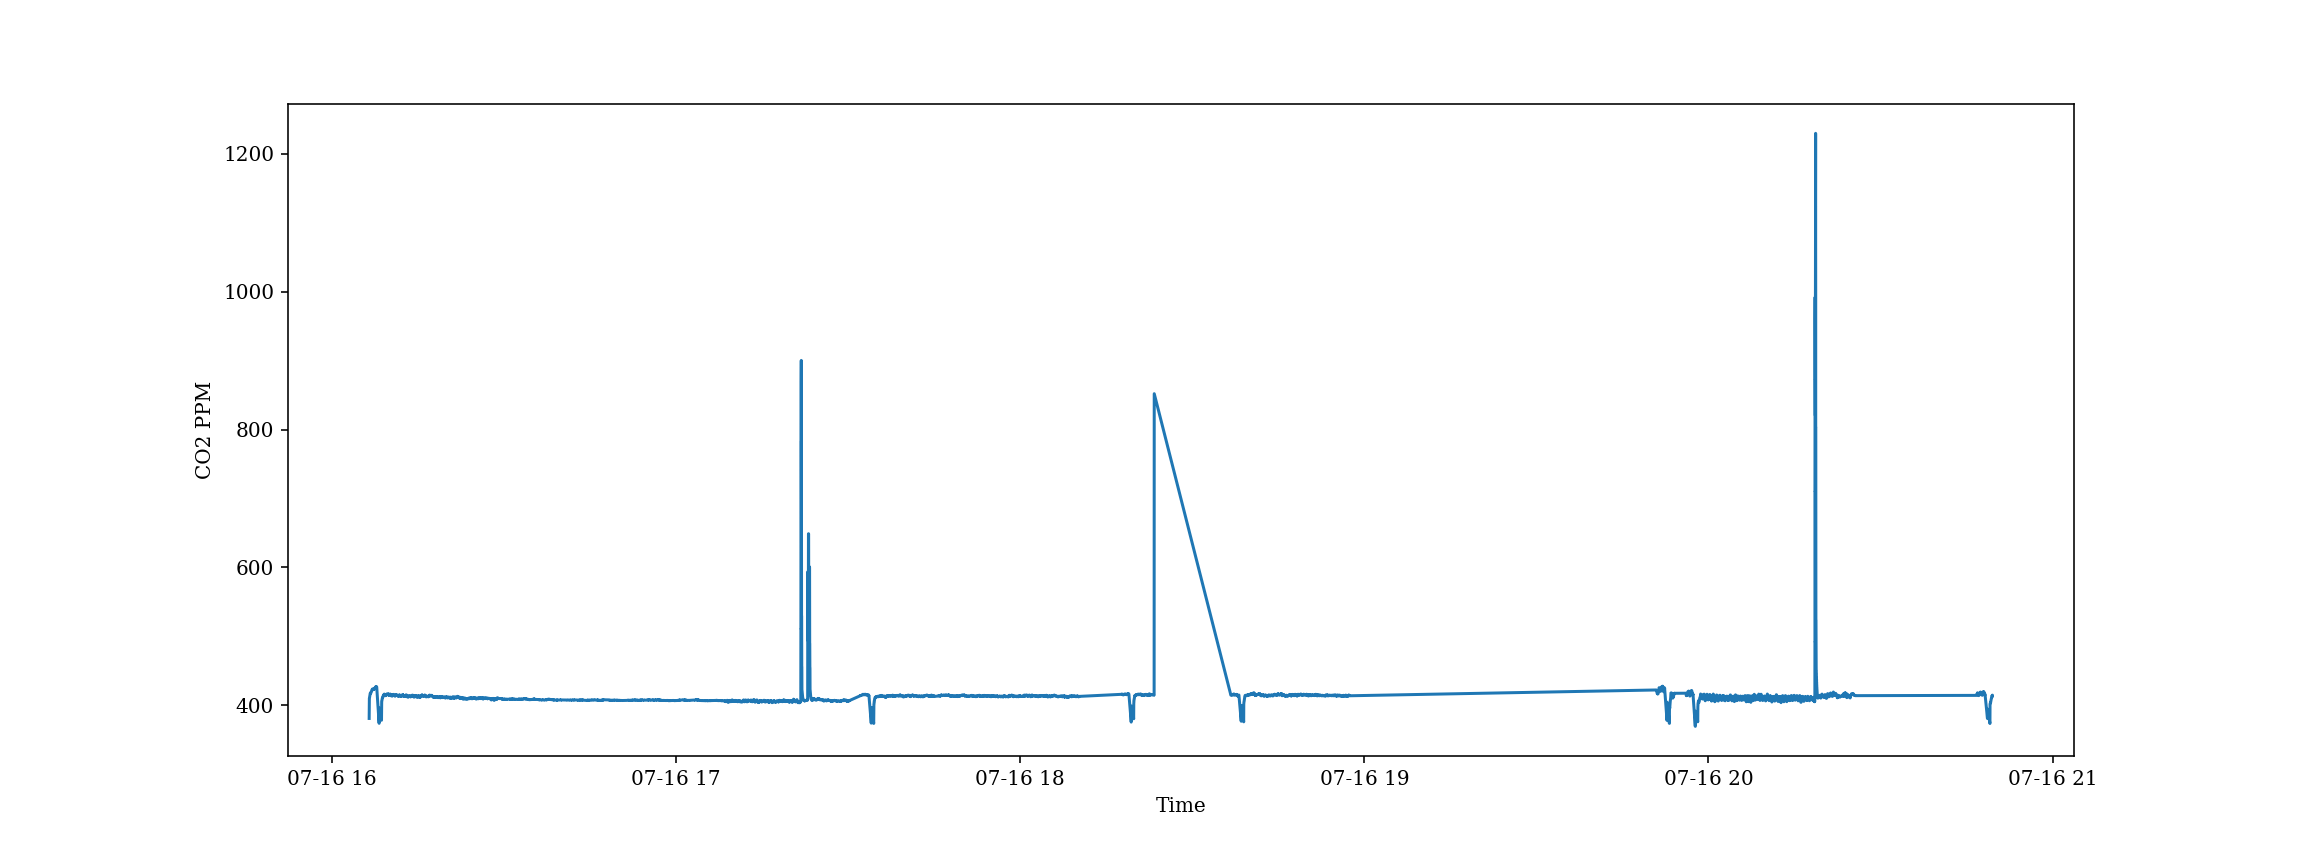

<IPython.core.display.Javascript object>


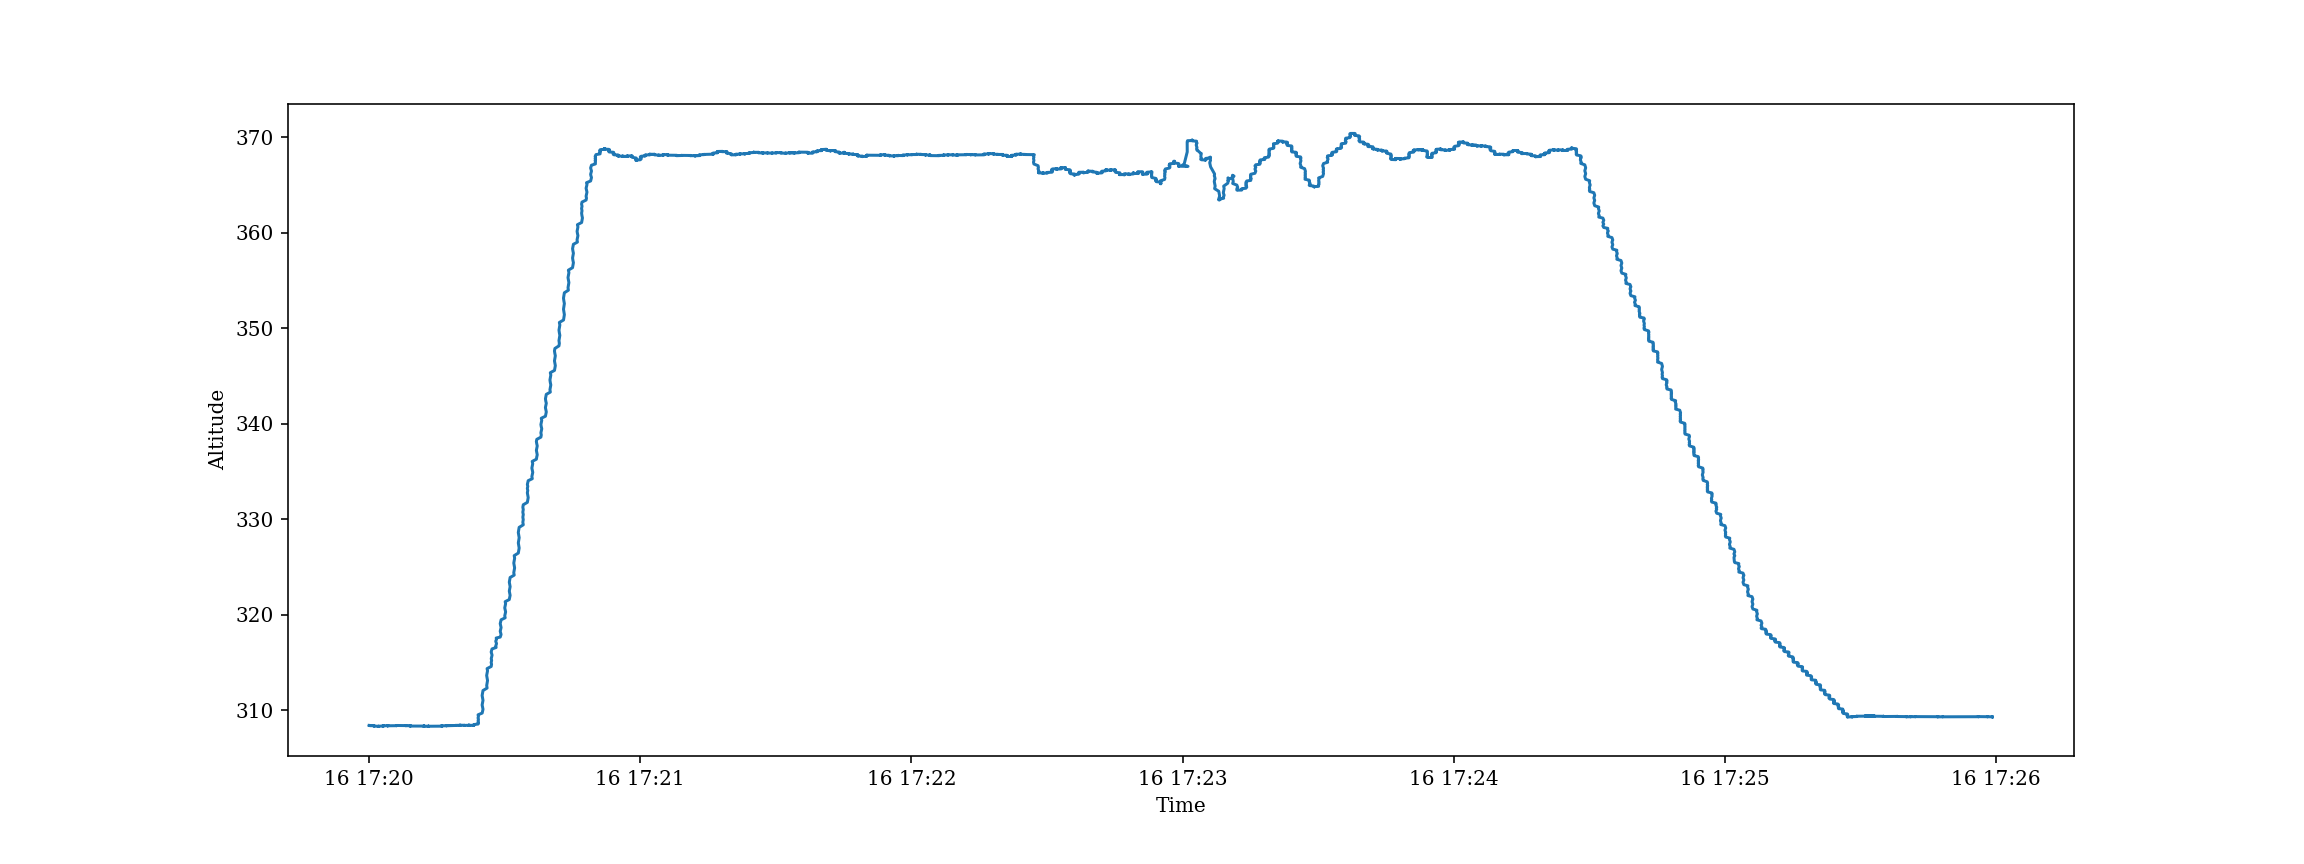

<IPython.core.display.Javascript object>


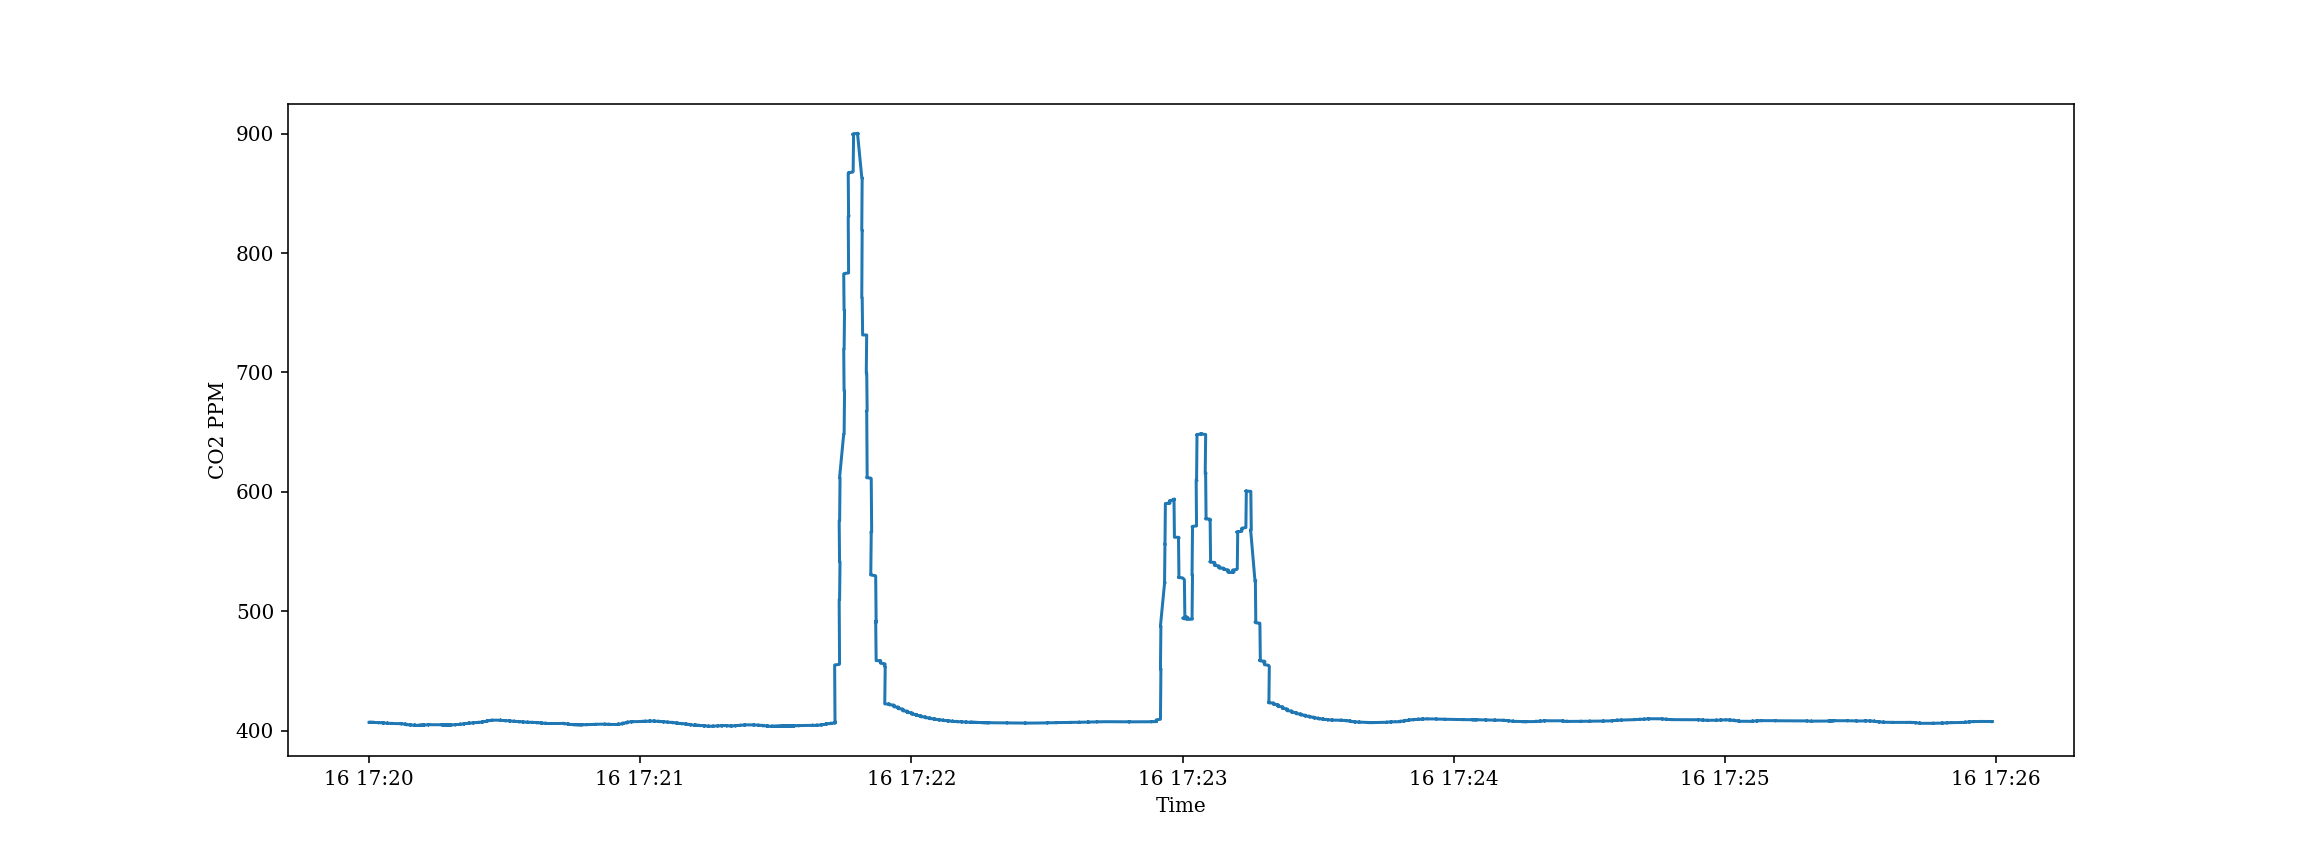

<IPython.core.display.Javascript object>


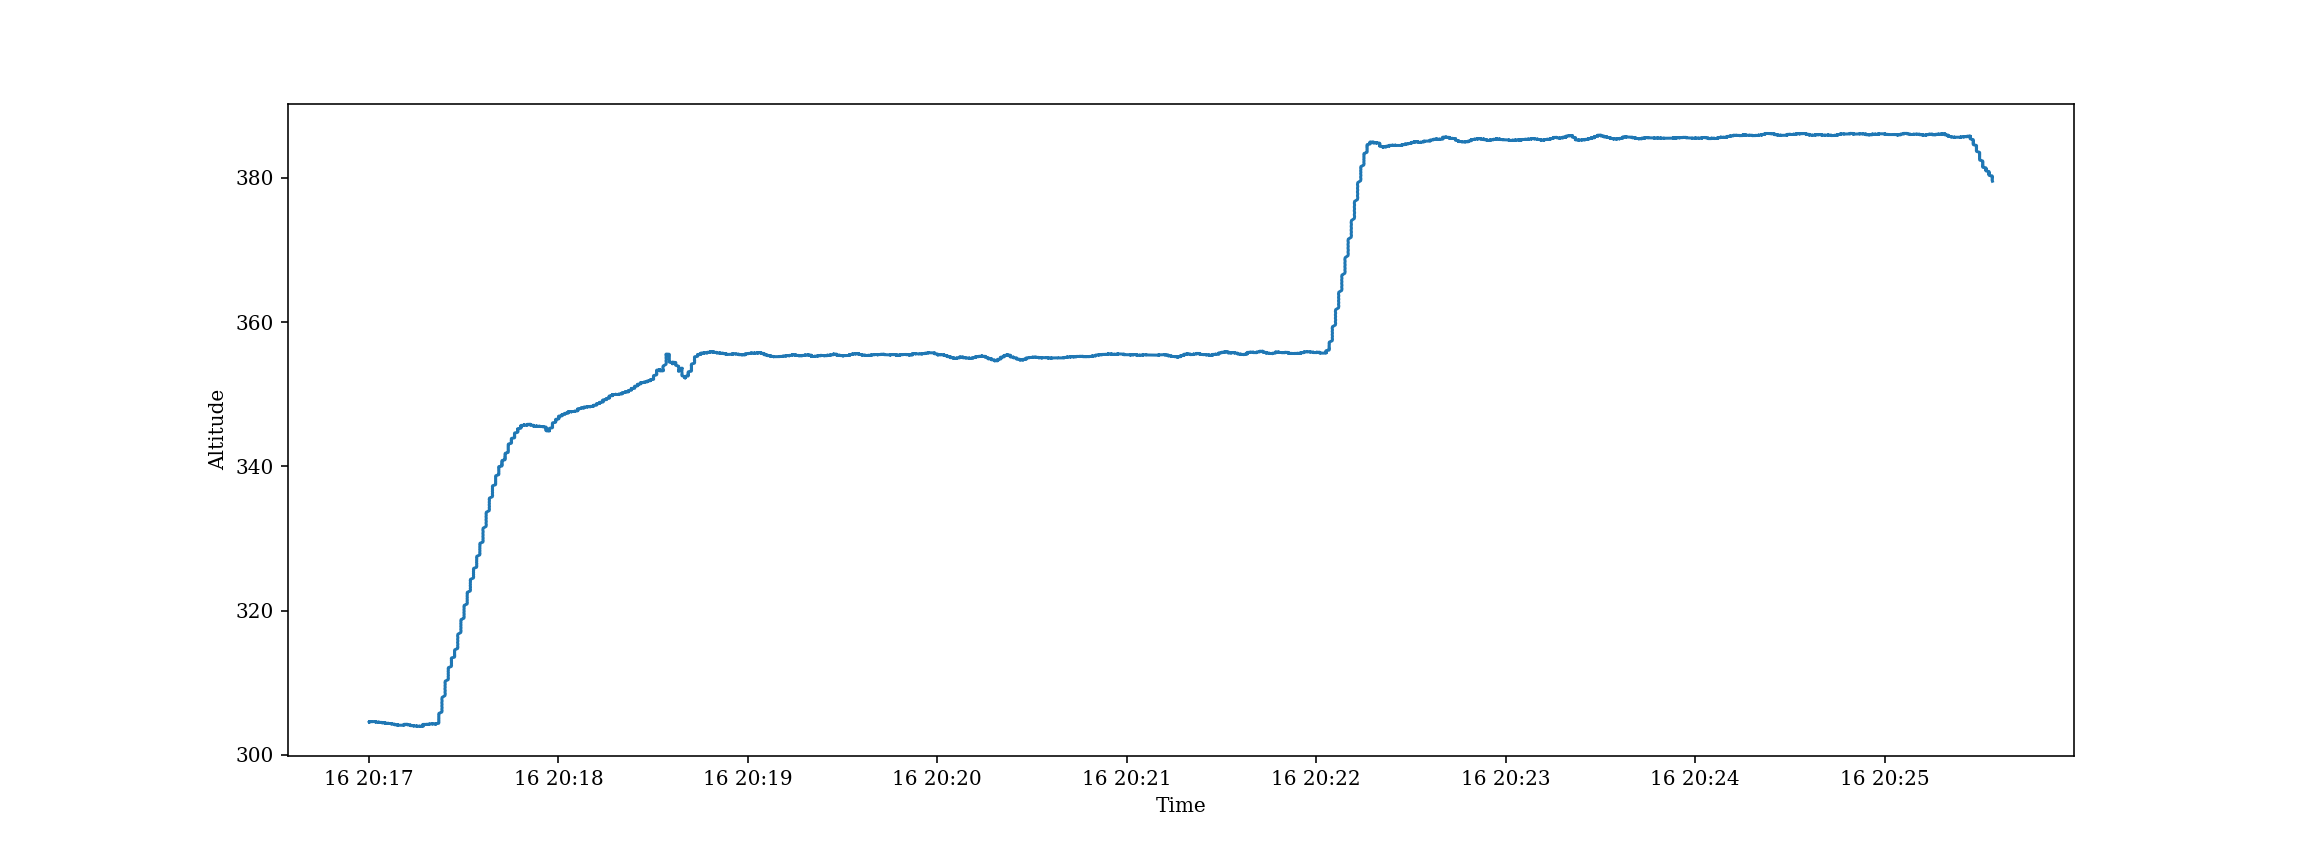

<IPython.core.display.Javascript object>


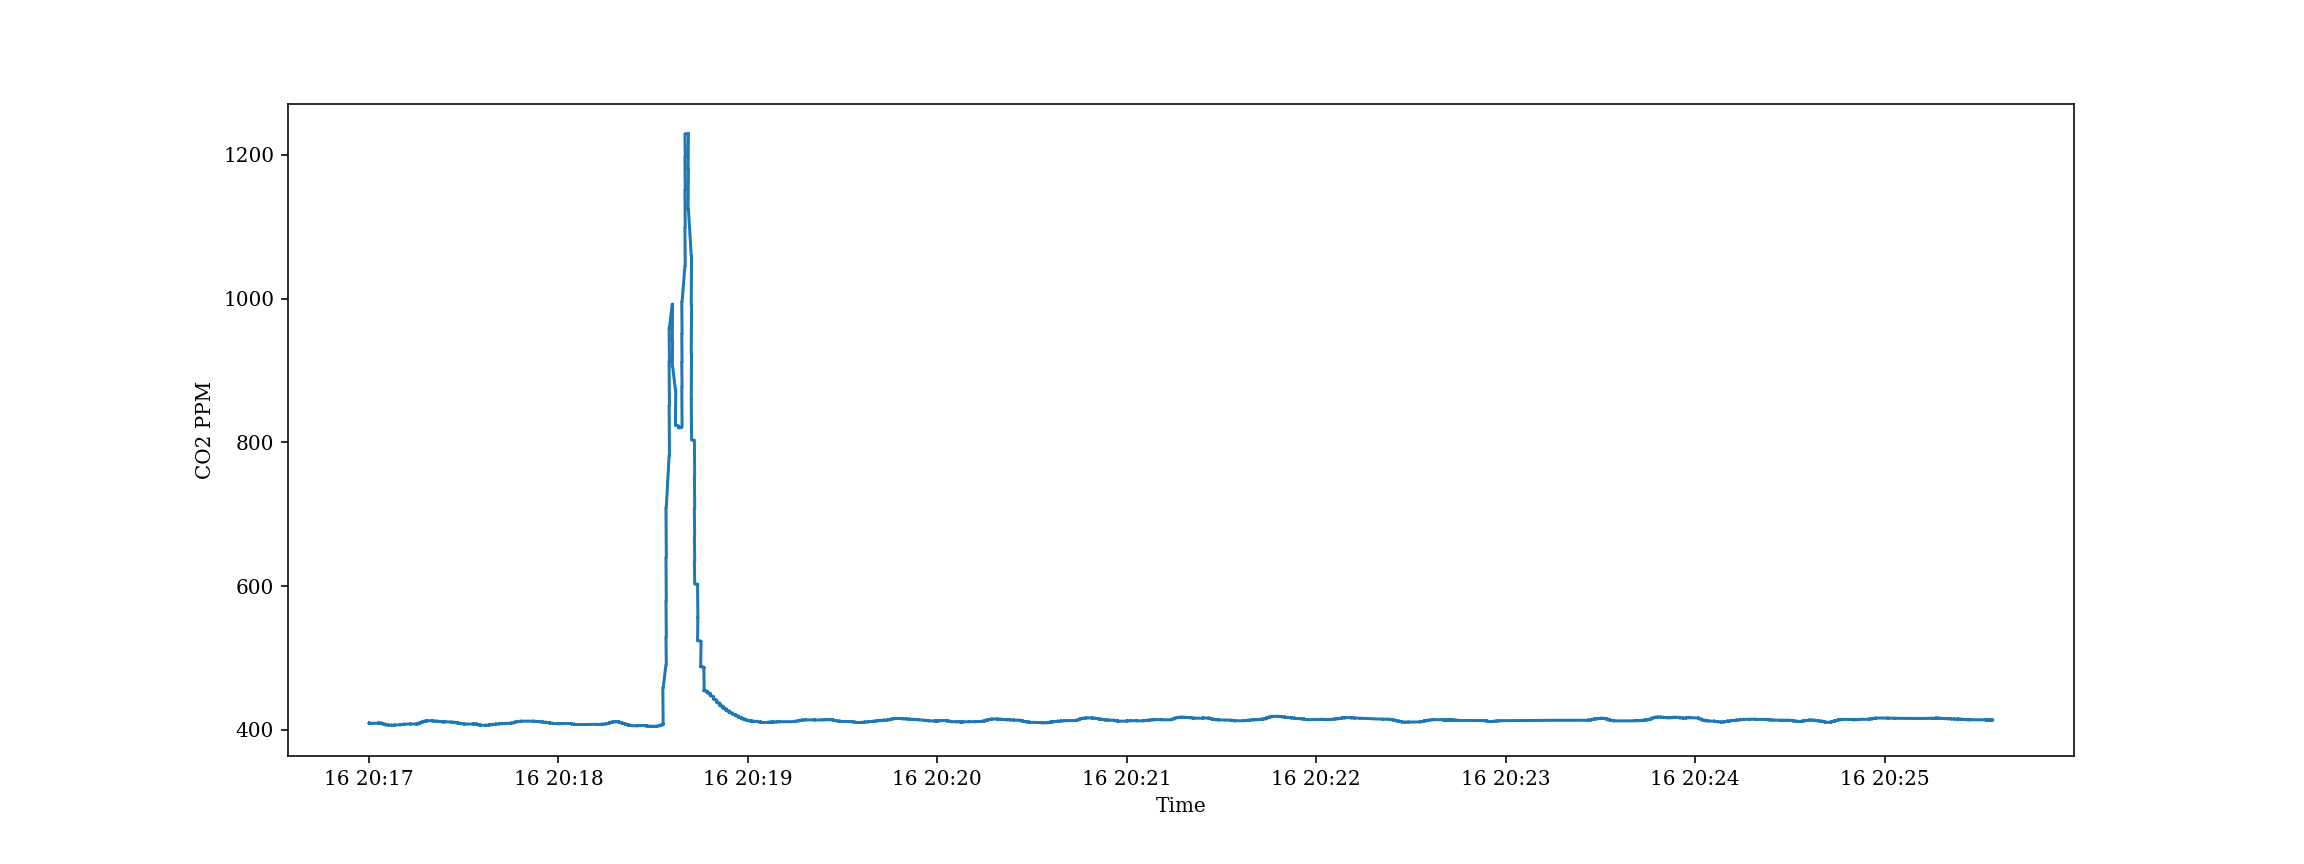

In [9]:
def display_data(name, readings, nlags=6):
    display_data_altitude(readings)
    
    display_readings(readings)
    
display_data('2023-7-15', day1)
display_data('2023-7-15', day1_flight1)
display_data('2023-7-16', day2)
display_data('2023-7-15', day2_flight1)
display_data('2023-7-15', day2_flight2)
